In [1]:
# Loading Libraries
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import log_hyperu as hyperu
import tgr as tgr
import math
import time
import csv
import re
import os

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Prediction Simulation Study
### Output Table

In [68]:
import os
import pandas as pd

# Placeholder for the folder path
folder_path = 'Simulation_20240815_131202_Final'

# Initialize an empty list to store the results
results = []

# Iterate through each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        # Extract scenario parameters from the file name
        scenario = tuple(map(int, file_name.replace('.xlsx', '').split('_')))
        
        # Load the Excel file
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        
        # Compute mean, median, and standard deviation of the loss for each method
        stats = df.groupby('Name')['Loss'].agg(['mean', 'median', 'std']).reset_index()
        
        # Reshape the data to have methods with stats as columns
        stats = stats.set_index('Name').unstack().to_frame().T
        stats.columns = [f"{method} {stat}" for method, stat in stats.columns]
        stats.index = pd.MultiIndex.from_tuples([scenario], names=['Samples', 'Features', 'Non-Zero Features'])
        
        # Append the results
        results.append(stats)

# Concatenate all results into a single DataFrame
final_df = pd.concat(results)

# Save the final DataFrame to a CSV file (optional)
# final_df.to_csv('simulation_summary.csv')

# Return the final DataFrame
final_df.head()


mean Arctan  mean Gaussian   mean LASSO  \
Samples Features Non-Zero Features                                            
100     10       1                     8.143253       8.143253     8.516406   
                 5                    55.223048      55.223048    55.147805   
                 9                    94.411489      94.411489    94.499127   
        200      100                2226.539478    2226.539478  2208.411564   
                 180                3646.989746    3646.989746  3636.414876   

                                       mean OLS   mean Ridge  \
Samples Features Non-Zero Features                             
100     10       1                     8.761460     9.398462   
                 5                    55.609065    56.055176   
                 9                    94.328465    91.867498   
        200      100                2216.253280  1830.304899   
                 180                3599.836971  2946.407048   

                                    mean TGR Setting 1  mean TGR Setting 2  \
Samples Features Non-Zero Features                                           
100     10       1                            8.760304            8.760058   
                 5                           55.608894           55.609779   
                 9                           94.327100           94.323201   
        200      100                       2216.269808         2212.338729   
                 180                       3606.204826         3601.480534   

                                    mean TGR Setting 3  median Arctan  \
Samples Features Non-Zero Features                                      
100     10       1                            8.761739       7.469255   
                 5                           55.609455      51.283241   
                 9                           94.331238      92.560654   
        200      100                       2219.282520    2269.682129   
                 180                       3597.845142    3732.005859   

                                    median Gaussian  ...  \
Samples Features Non-Zero Features                   ...   
100     10       1                         7.469255  ...   
                 5                        51.283241  ...   
                 9                        92.560654  ...   
        200      100                    2269.682129  ...   
                 180                    3732.005859  ...   

                                    median TGR Setting 2  \
Samples Features Non-Zero Features                         
100     10       1                              8.808549   
                 5                             49.950260   
                 9                             92.504631   
        200      100                         2135.835449   
                 180                         3742.280762   

                                    median TGR Setting 3  std Arctan  \
Samples Features Non-Zero Features                                     
100     10       1                              8.806270    2.510760   
                 5                             49.941757   20.503470   
                 9                             92.511185   20.533786   
        200      100                         2161.749512  739.514454   
                 180                         3747.844482  772.851812   

                                    std Gaussian   std LASSO     std OLS  \
Samples Features Non-Zero Features                                         
100     10       1                      2.510760    2.644609    2.473511   
                 5                     20.503470   19.635095   20.961143   
                 9                     20.533786   21.803765   20.518257   
        200      100                  739.514454  787.768443  723.275216   
                 180                  772.851812  839.113696  815.794459   

                                     std Ridge  std TGR Setting 1  \
Samples Features Non-Zero

In [69]:
# Placeholder paths for the original and Gaussian data folders
original_folder_path = 'Simulation_20240815_131202_Final'
gaussian_folder_path = 'Simulation_20240822_Gaussian'

# Load the original final_df (assumed to be in the environment)
# You can replace this with code to load the existing final_df DataFrame if not in the environment

# Iterate through each file in the Gaussian folder to replace the Gaussian data in final_df
for file_name in os.listdir(gaussian_folder_path):
    if file_name.endswith('.xlsx'):
        # Extract scenario parameters from the file name
        scenario = tuple(map(int, file_name.replace('.xlsx', '').split('_')))
        
        # Load the Gaussian Excel file
        gaussian_file_path = os.path.join(gaussian_folder_path, file_name)
        gaussian_df = pd.read_excel(gaussian_file_path)
        
        # Extract only the Gaussian rows
        gaussian_data = gaussian_df[gaussian_df['Name'] == 'Gaussian']
        
        # Load the corresponding original Excel file
        original_file_path = os.path.join(original_folder_path, file_name)
        original_df = pd.read_excel(original_file_path)
        
        # Remove the old Gaussian data from the original dataframe
        original_df = original_df[original_df['Name'] != 'Gaussian']
        
        # Append the correct Gaussian data
        updated_df = pd.concat([original_df, gaussian_data])
        
        # Replace the original scenario data in the final_df with the updated data
        stats = updated_df.groupby('Name')['Loss'].agg(['mean', 'median', 'std']).reset_index()
        stats = stats.set_index('Name').unstack().to_frame().T
        stats.columns = [f"{method} {stat}" for method, stat in stats.columns]
        stats.index = pd.MultiIndex.from_tuples([scenario], names=['Samples', 'Features', 'Non-Zero Features'])
        
        # Update the relevant row in final_df
        final_df.update(stats)

# Save or display the updated final_df
final_df.head()

mean Arctan  mean Gaussian   mean LASSO  \
Samples Features Non-Zero Features                                            
100     10       1                     8.143253      10.027221     8.516406   
                 5                    55.223048      50.321092    55.147805   
                 9                    94.411489      91.228384    94.499127   
        200      100                2226.539478    1827.872876  2208.411564   
                 180                3646.989746    3715.862744  3636.414876   

                                       mean OLS   mean Ridge  \
Samples Features Non-Zero Features                             
100     10       1                     8.761460     9.398462   
                 5                    55.609065    56.055176   
                 9                    94.328465    91.867498   
        200      100                2216.253280  1830.304899   
                 180                3599.836971  2946.407048   

                                    mean TGR Setting 1  mean TGR Setting 2  \
Samples Features Non-Zero Features                                           
100     10       1                            8.760304            8.760058   
                 5                           55.608894           55.609779   
                 9                           94.327100           94.323201   
        200      100                       2216.269808         2212.338729   
                 180                       3606.204826         3601.480534   

                                    mean TGR Setting 3  median Arctan  \
Samples Features Non-Zero Features                                      
100     10       1                            8.761739       7.469255   
                 5                           55.609455      51.283241   
                 9                           94.331238      92.560654   
        200      100                       2219.282520    2269.682129   
                 180                       3597.845142    3732.005859   

                                    median Gaussian  ...  \
Samples Features Non-Zero Features                   ...   
100     10       1                        10.732989  ...   
                 5                        49.699554  ...   
                 9                        95.052094  ...   
        200      100                    1959.256592  ...   
                 180                    3742.510986  ...   

                                    median TGR Setting 2  \
Samples Features Non-Zero Features                         
100     10       1                              8.808549   
                 5                             49.950260   
                 9                             92.504631   
        200      100                         2135.835449   
                 180                         3742.280762   

                                    median TGR Setting 3  std Arctan  \
Samples Features Non-Zero Features                                     
100     10       1                              8.806270    2.510760   
                 5                             49.941757   20.503470   
                 9                             92.511185   20.533786   
        200      100                         2161.749512  739.514454   
                 180                         3747.844482  772.851812   

                                    std Gaussian   std LASSO     std OLS  \
Samples Features Non-Zero Features                                         
100     10       1                      3.428013    2.644609    2.473511   
                 5                     17.244034   19.635095   20.961143   
                 9                     33.291069   21.803765   20.518257   
        200      100                  444.321523  787.768443  723.275216   
                 180                  938.209746  839.113696  815.794459   

                                     std Ridge  std TGR Setting 1  \
Samples Features Non-Zero

In [74]:
# Extract columns related to mean and std
mean_cols = {col.replace('mean', ''): col for col in final_df.columns if 'mean' in col}
std_cols = {col.replace('std', ''): col for col in final_df.columns if 'std' in col}

# Create a new DataFrame to store the merged columns
merged_df = pd.DataFrame(index=final_df.index)

# Merge the mean and std columns
for method in mean_cols.keys():
    if method in std_cols:
        merged_df[method] = round(final_df[mean_cols[method]],3).astype(str) + ' (' + round(final_df[std_cols[method]],3).astype(str) + ')'

# Add back the median columns unchanged
median_cols = [col for col in final_df.columns if 'median' in col]
merged_df = pd.concat([merged_df, final_df[median_cols]], axis=1)

# Display or save the updated DataFrame
merged_df.head()

# Optionally save to a CSV file
# merged_df.to_csv('merged_methods_summary.csv', index=False)


Arctan            Gaussian  \
Samples Features Non-Zero Features                                           
100     10       1                       8.143 (2.511)      10.027 (3.428)   
                 5                     55.223 (20.503)     50.321 (17.244)   
                 9                     94.411 (20.534)     91.228 (33.291)   
        200      100                2226.539 (739.514)  1827.873 (444.322)   
                 180                 3646.99 (772.852)   3715.863 (938.21)   

                                                 LASSO                 OLS  \
Samples Features Non-Zero Features                                           
100     10       1                       8.516 (2.645)       8.761 (2.474)   
                 5                     55.148 (19.635)     55.609 (20.961)   
                 9                     94.499 (21.804)     94.328 (20.518)   
        200      100                2208.412 (787.768)  2216.253 (723.275)   
                 180                3636.415 (839.114)  3599.837 (815.794)   

                                                 Ridge       TGR Setting 1  \
Samples Features Non-Zero Features                                           
100     10       1                        9.398 (2.78)        8.76 (2.475)   
                 5                     56.055 (19.489)     55.609 (20.964)   
                 9                     91.867 (22.567)     94.327 (20.518)   
        200      100                 1830.305 (737.83)    2216.27 (728.55)   
                 180                2946.407 (597.781)  3606.205 (814.385)   

                                         TGR Setting 2       TGR Setting 3  \
Samples Features Non-Zero Features                                           
100     10       1                        8.76 (2.474)       8.762 (2.475)   
                 5                      55.61 (20.962)     55.609 (20.965)   
                 9                     94.323 (20.517)     94.331 (20.516)   
        200      100                 2212.339 (723.82)  2219.283 (725.999)   
                 180                3601.481 (818.954)  3597.845 (812.657)   

                                    median Arctan  median Gaussian  \
Samples Features Non-Zero Features                                   
100     10       1                       7.469255        10.732989   
                 5                      51.283241        49.699554   
                 9                      92.560654        95.052094   
        200      100                  2269.682129      1959.256592   
                 180                  3732.005859      3742.510986   

                                    median LASSO   median OLS  median Ridge  \
Samples Features Non-Zero Features                                            
100     10       1                      7.508032     8.811548      8.607406   
                 5                     50.271812    49.930897     54.371986   
                 9                     90.789352    92.505119     89.312599   
        200      100                 2258.939941  2141.013916   1814.401123   
                 180                 3729.429688  3745.418457   2888.111328   

                                    median TGR Setting 1  \
Samples Features Non-Zero Features                         
100     10       1                              8.806631   
                 5                             49.941185   
                 9                             92.499771   
        200      100                         2132.870117   
                 180                         3775.462402   

                                    median TGR Setting 2  median TGR Setting 3  
Samples Features Non-Zero Features                                              
100     10       1                              8.808549              8.806270  
                 5                             49.950260             49.941757  
                 9                             92.504631             9

In [75]:
# Extract columns related to mean and median
mean_cols = [col for col in final_df.columns if 'mean' in col]
median_cols = [col for col in final_df.columns if 'median' in col]

# Determine the best method based on mean (smallest mean loss) and remove "mean_" prefix
best_mean_methods = final_df[mean_cols].idxmin(axis=1).str.replace('mean ', '')

# Determine the best method based on median (smallest median loss) and remove "median_" prefix
best_median_methods = final_df[median_cols].idxmin(axis=1).str.replace('median ', '')

# Create a new DataFrame to store the scenario values and the best methods
best_methods_df = final_df.index.to_frame(index=False)  # Get the scenario values from the MultiIndex
best_methods_df['Best_Method_Mean'] = best_mean_methods.values
best_methods_df['Best_Method_Median'] = best_median_methods.values

# Display the new DataFrame
best_methods_df.head()

latex_table_best_methods = best_methods_df.to_latex(index=False)
with open('latex_best_methods.tex', 'w') as file:
    file.write(latex_table_best_methods)


In [78]:
# Get Table to LATEX
#df = pd.read_excel('summary_statistics.xlsx', sheet_name='Final')
latex_table_simulation = merged_df.to_latex(index=True)
with open('latex_table_simulation.tex', 'w') as file:
    file.write(latex_table_simulation)

In [79]:
import re

# Path to the input file
input_file_path = 'outputtable.txt'

# Path to the output file
output_file_path = 'outputtable_adjusted.txt'

# Read the content of the input file
with open(input_file_path, 'r') as file:
    content = file.read()

# Regular expression pattern to find "mean (std)"
pattern = r"(\d+\.\d+)\s\((\d+\.\d+)\)"
replacement = r"\\makecell{\1 \\\\ (\2)}"

# Perform the replacement
adjusted_content = re.sub(pattern, replacement, content)

# Save the adjusted content back to a new text file
with open(output_file_path, 'w') as file:
    file.write(adjusted_content)

print(f"Adjusted file saved to {output_file_path}")


Adjusted file saved to outputtable_adjusted.txt


### Boxplot of Specific Scenario

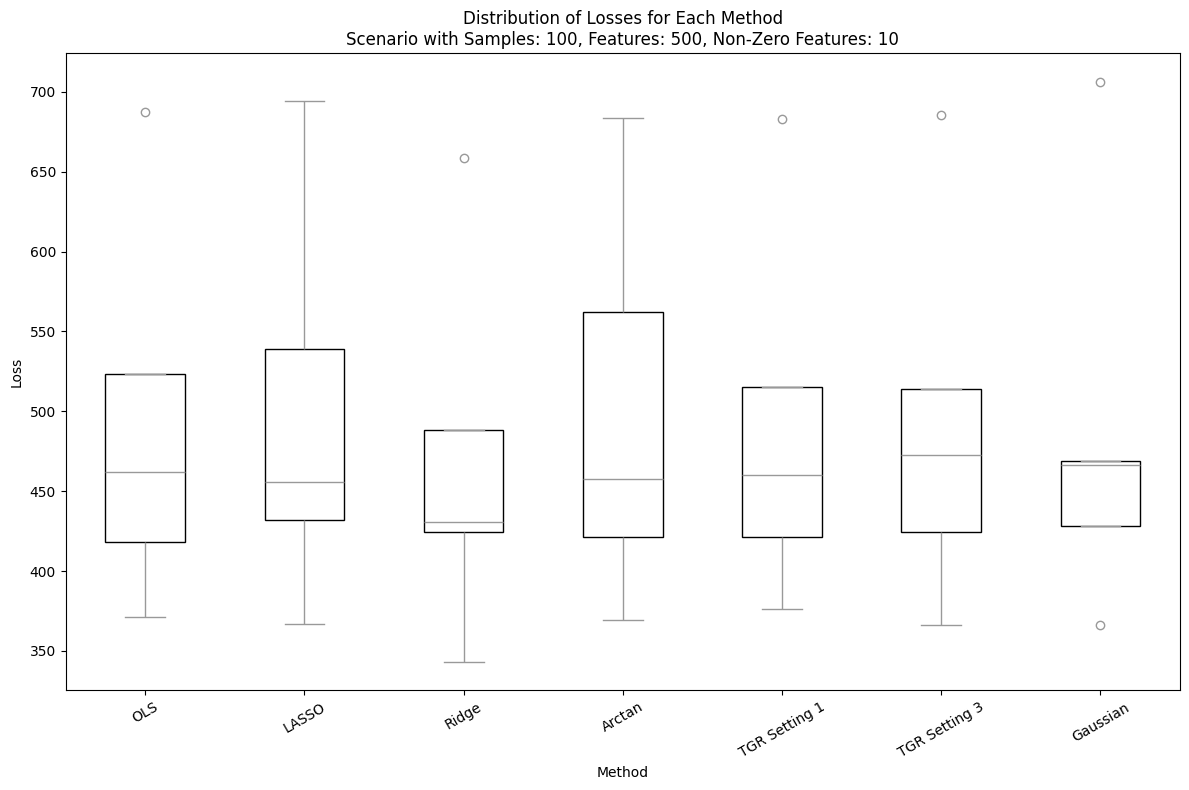

In [106]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots_for_scenario(samples, features, non_zero_features, original_folder_path, gaussian_folder_path):
    # Construct the file name based on the scenario parameters
    file_name = f"{samples}_{features}_{non_zero_features}.xlsx"
    
    # Load the original data
    original_file_path = os.path.join(original_folder_path, file_name)
    original_df = pd.read_excel(original_file_path)
    
    # Check if the Gaussian data needs to be replaced
    gaussian_file_path = os.path.join(gaussian_folder_path, file_name)
    if os.path.exists(gaussian_file_path):
        gaussian_df = pd.read_excel(gaussian_file_path)
        # Extract only the Gaussian rows
        gaussian_data = gaussian_df[gaussian_df['Name'] == 'Gaussian']
        
        # Remove the old Gaussian data from the original dataframe
        original_df = original_df[original_df['Name'] != 'Gaussian']
        
        # Append the correct Gaussian data
        original_df = pd.concat([original_df, gaussian_data])
    
    # Plot the boxplots for each method
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Name', y='Loss', data=original_df, color='white', width=0.5, boxprops=dict(facecolor='none', edgecolor='black'))
    plt.title(f"Distribution of Losses for Each Method\nScenario with Samples: {samples}, Features: {features}, Non-Zero Features: {non_zero_features}")
    plt.xlabel("Method")
    plt.ylabel("Loss")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig(f"021_simulation_figures/Scenarion_100_200_20.png")
    plt.show()

# Example usage:
plot_boxplots_for_scenario(100, 200, 20, 'Simulation_20240815_131202_Final', 'Simulation_20240822_Gaussian')


### Computational Performance

In [32]:
import itertools
import time

# Set random seed for reproducibility
torch.manual_seed(123) # 42
np.random.seed(123) # 42

# Step 1: Generate synthetic data using scenario
n_epochs = 500
runs = 1

n_samples = [100]
n_features = [i+1 for i in range(75)]
n_nonzero = [0.1]

scenario_combinations = list(itertools.product(n_samples, n_features, n_nonzero))
time_list = list()
# Make new simulation folder
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
simulation_folder_path = f'Simulation_{current_datetime}'
os.makedirs(simulation_folder_path, exist_ok=True)

counter=0
for scen in scenario_combinations:
    start_time = time.time()
    output_list = list() # Contains Tuples with (METHOD, LAMBDA, LOSS, COEFS)
    counter = counter + 1
    for run in range(runs):
        n_samples = scen[0]
        n_features = scen[1]
        n_nonzero = math.ceil(scen[2]*scen[1])
        # True coefficients with sparsity (many coefficients are zero)
        true_coefficients = torch.zeros(n_features)
        true_coefficients[:n_nonzero] = torch.randn(n_nonzero)

        # Generate features
        X = torch.randn(n_samples, n_features)

        # Generate targets with noise
        noise = torch.randn(n_samples) * 0.5
        y = X @ true_coefficients + noise

        # Step 2: Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Step 3: Implement OLS and Lasso regression using PyTorch

        class LinearRegression(nn.Module):
            def __init__(self, n_features):
                super(LinearRegression, self).__init__()
                self.linear = nn.Linear(n_features, 1, bias=False)
                
            def forward(self, x):
                return self.linear(x)

        def train_model(model, X_train, y_train, lr=0.01, n_epochs=500):
            criterion = nn.MSELoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            
            for epoch in range(n_epochs):
                model.train()
                
                optimizer.zero_grad()
                outputs = model(X_train).squeeze()
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()
                
            return model
        
        # Train TGR Model - Setting 1
        tgr_reg_strength = 0.02
        tgr_model1 = LinearRegression(n_features)
        def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
            mse_loss = nn.MSELoss()(output, target)
            phi = torch.tensor((2*c)/((kappa**2)*a))
            tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

            return mse_loss + tgr_loss

        optimizer = torch.optim.SGD(tgr_model1.parameters(), lr=0.01)

        for epoch in range(n_epochs):
            tgr_model1.train()
            
            optimizer.zero_grad()
            outputs = tgr_model1(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model1, tgr_reg_strength, 0.75, 0.1, 2)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model1.parameters(), 1.0)
            optimizer.step()
        
        # Train TGR Model - Setting 2
        tgr_model2 = LinearRegression(n_features)
        def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
            mse_loss = nn.MSELoss()(output, target)
            phi = torch.tensor((2*c)/((kappa**2)*a))
            tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

            return mse_loss + tgr_loss

        optimizer = torch.optim.SGD(tgr_model2.parameters(), lr=0.01)
        tgr_reg_strength = 0.04
        for epoch in range(n_epochs):
            tgr_model2.train()
            
            optimizer.zero_grad()
            outputs = tgr_model2(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model2, tgr_reg_strength, 5, 0.01, 2)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model2.parameters(), 1.0)
            optimizer.step()

        # Train TGR Model - Setting 3
        tgr_reg_strength = 0.13
        tgr_model3 = LinearRegression(n_features)
        def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
            mse_loss = nn.MSELoss()(output, target)
            phi = torch.tensor((2*c)/((kappa**2)*a))
            tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

            return mse_loss + tgr_loss

        optimizer = torch.optim.SGD(tgr_model3.parameters(), lr=0.01)

        for epoch in range(n_epochs):
            tgr_model3.train()
            
            optimizer.zero_grad()
            outputs = tgr_model3(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model3, tgr_reg_strength, 0.51, 0.01, 1)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model3.parameters(), 1.0)
            optimizer.step()

        # END RUNS LOOP
    end_time = time.time()
    time_list.append((scen[1],round(end_time - start_time,5)))
    print(f"Scenario {scen[1]} done!")
        

df_time = pd.DataFrame(time_list, columns=['Variables', 'TimeInSeconds'])


Scenario 1 done!
Scenario 2 done!
Scenario 3 done!
Scenario 4 done!
Scenario 5 done!
Scenario 6 done!
Scenario 7 done!
Scenario 8 done!
Scenario 9 done!
Scenario 10 done!
Scenario 11 done!
Scenario 12 done!
Scenario 13 done!
Scenario 14 done!
Scenario 15 done!
Scenario 16 done!
Scenario 17 done!
Scenario 18 done!
Scenario 19 done!
Scenario 20 done!
Scenario 21 done!
Scenario 22 done!
Scenario 23 done!
Scenario 24 done!
Scenario 25 done!
Scenario 26 done!
Scenario 27 done!
Scenario 28 done!
Scenario 29 done!
Scenario 30 done!
Scenario 31 done!
Scenario 32 done!
Scenario 33 done!
Scenario 34 done!
Scenario 35 done!
Scenario 36 done!
Scenario 37 done!
Scenario 38 done!
Scenario 39 done!
Scenario 40 done!
Scenario 41 done!
Scenario 42 done!
Scenario 43 done!
Scenario 44 done!
Scenario 45 done!
Scenario 46 done!
Scenario 47 done!
Scenario 48 done!
Scenario 49 done!
Scenario 50 done!
Scenario 51 done!
Scenario 52 done!
Scenario 53 done!
Scenario 54 done!
Scenario 55 done!
Scenario 56 done!
S

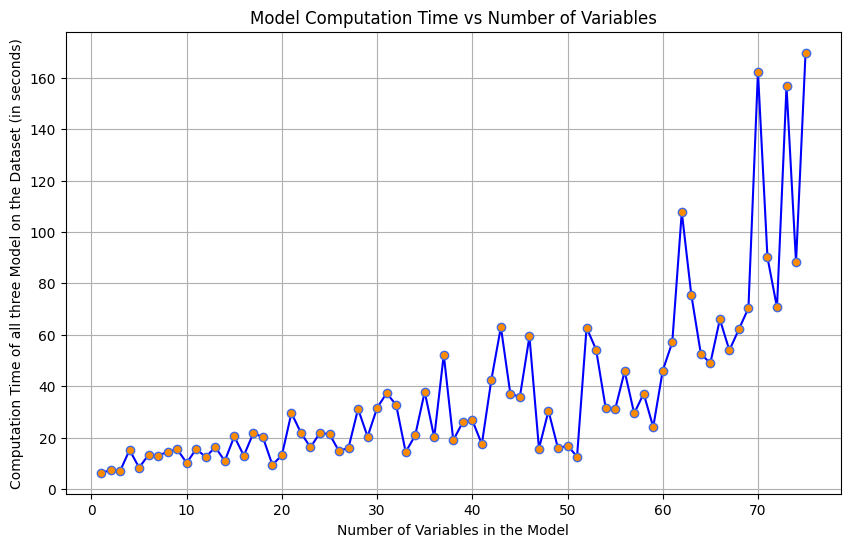

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(df_time['Variables'], df_time['TimeInSeconds'], marker='o', linestyle='-', color='b',markerfacecolor='darkorange', markeredgecolor='royalblue')

# Set the title and labels
plt.title('Model Computation Time vs Number of Variables')
plt.xlabel('Number of Variables in the Model')
plt.ylabel('Computation Time of all three Model on the Dataset (in seconds)')

df_time['Variables'][67]
# Display the plot
plt.grid(True)
plt.savefig(f"021_simulation_figures/ComputationTime_Example.png")

plt.show()